<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/CNN_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -o dermamnist.npz https://zenodo.org/records/10519652/files/dermamnist.npz?download=1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.8M  100 18.8M    0     0  9433k      0  0:00:02  0:00:02 --:--:-- 9437k


## *Download* dos dados

Utilizaremos da bibilioteca curl para baixar a base de dados DermaMNIST. Usaremos o comando da seguinte forma

```
curl -o nome_do_arquivo link_para_download
```


## Carregando os dados somente do conjunto de validação e teste

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import numpy as np

# Carrega a base de dados
dermamnist = np.load("dermamnist.npz") # O arquivo chama-se dermamnist.npz (definido no curl)

x_val = dermamnist['val_images']
y_val = dermamnist['val_labels']

x_test = dermamnist['test_images']
y_test = dermamnist['test_labels']

# 1. (1,0) Descreva o modelo treinado na base de dados DermaMNIST. Qual foi a melhor arquitetura obtida no Trabalho 1? Não esqueça de informar a taxa de acerto no conjunto de teste.

## Resposta:

 O modelo `ConvNet3` foi o modelo que apresentou o melhor resultado no conjunto de teste.
- ### Acurácia = 0.736
- ### F1 = 0.722


A rede é uma rede neural convolucional (CNN) construída para tarefas de classificação. Vou descrever cada componente do modelo em detalhes:

### Estrutura Geral

O modelo `ConvNet3` consiste em duas partes principais:
1. **Camada Convolucional (conv_layer)**: Responsável por extrair características da imagem de entrada.
2. **Camada Densa (dense_layer)**: Responsável por realizar a classificação com base nas características extraídas.

### Camada Convolucional (conv_layer)

A camada convolucional é composta por uma sequência de camadas convolucionais, de normalização, de ativação e de pooling. Vamos detalhar cada uma dessas camadas:

1. **Primeira Convolução**:
   - **Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))**: Aplica uma operação de convolução 2D com 48 filtros de tamanho \(3 \times 3\). A imagem de entrada tem 3 canais (por exemplo, uma imagem RGB). A operação mantém as dimensões da imagem de entrada devido ao padding de 1.
   - **BatchNorm2d(48)**: Normaliza os resultados da convolução com 48 canais, ajudando a estabilizar o processo de treinamento.
   - **PReLU(num_parameters=1)**: Aplica a função de ativação PReLU, que é uma versão parametrizada da ReLU.
   - **MaxPool2d(kernel_size=3, stride=2)**: Reduz as dimensões espaciais da imagem pela metade (aproximadamente), utilizando uma operação de max pooling com uma janela \(3 \times 3\) e stride 2.

2. **Segunda Convolução**:
   - **Conv2d(48, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))**: Aplica uma convolução com 256 filtros de tamanho \(5 \times 5\) sobre os 48 mapas de características da camada anterior. O padding de 1 é utilizado.
   - **BatchNorm2d(256)**: Normaliza os 256 mapas de características.
   - **PReLU(num_parameters=1)**: Aplica a função de ativação PReLU.
   - **MaxPool2d(kernel_size=4, stride=2)**: Reduz as dimensões espaciais utilizando uma janela \(4 \times 4\) e stride 2.

3. **Terceira Convolução**:
   - **Conv2d(256, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))**: Aplica uma convolução com 48 filtros de tamanho \(3 \times 3\) sobre os 256 mapas de características da camada anterior.
   - **BatchNorm2d(48)**: Normaliza os 48 mapas de características.
   - **PReLU(num_parameters=1)**: Aplica a função de ativação PReLU.

4. **Pooling Adaptativo**:
   - **AdaptiveMaxPool2d(output_size=(1, 1))**: Reduz as dimensões espaciais para um tamanho fixo de \(1 \times 1\), independentemente do tamanho de entrada, agregando as características globais da imagem.

### Camada Densa (dense_layer)

A camada densa transforma as características extraídas em classes preditas:

1. **Linear(in_features=48, out_features=7)**: Uma camada totalmente conectada (fully connected) que mapeia os 48 características de entrada para 7 saídas. Esta camada realiza a classificação final em 7 classes.
2. #### **Dropout(p=0.5)**: Aplica dropout com uma taxa de 50%, ajudando a prevenir overfitting durante o treinamento.

### Resumo:
- O modelo `ConvNet3` foi projetado para processar imagens de entrada e classificá-las em 7 categorias. Ele utiliza uma combinação de convoluções, normalização por batch, funções de ativação PReLU, pooling e uma camada totalmente conectada com dropout. A arquitetura combina camadas convolucionais profundas para extração de características complexas com uma camada densa final para a tarefa de classificação.

### Helper Functions

In [4]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from collections import OrderedDict
from sklearn.metrics import f1_score

import torch
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader


def deterministic(rep=True, MANUAL_SEED=42):
    if rep:
        np.random.seed(MANUAL_SEED)
        torch.manual_seed(MANUAL_SEED)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(MANUAL_SEED)
            torch.cuda.manual_seed_all(MANUAL_SEED)
        torch.backends.cudnn.enabled = False
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        print(f'Experimento deterministico, seed: {MANUAL_SEED}')
        print(f'Existe {torch.cuda.device_count()} GPU {torch.cuda.get_device_name(0)} disponível.')
    else:
        print('Experimento randomico')

def count_parameters(model):
    # Conta o numero de parametros se o parametro precisa de gradiente
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

if (torch.cuda.is_available()):
  device = 'cuda'
else:
  device = 'cpu'
print("Using", device)


def model_test(model, loader, device='cpu'):
    # Colaca o modelo em modo de avaliação (desliga os dropouts)
    model.eval()

    # Listas para avaliação do modelo
    preds, trues, logits_preds = [],[],[]

    # Para cada batch (imagem e label)...
    for x, y in loader:
        y = y.flatten()

        # Não calcula nenhum gradiente
        with torch.no_grad():
            y_pred = model(
            x.to(device),
            )

        # Calcula as predições e envia os labels para cpu
        logits_preds += y_pred.cpu().numpy().tolist()
        preds += y_pred.argmax(-1).cpu().numpy().tolist()
        trues += y.cpu().numpy().tolist()

    # Calcula a acuracia
    preds = np.array(preds)
    trues = np.array(trues)

    acc = (1.* (preds==trues)).mean()

    # Calcula o f1 com weighted (considera o desbalanceamento do dataset)
    f1 = f1_score(trues, preds, average='weighted', zero_division=0)

    return acc, f1, trues, preds, logits_preds


# Para melhor diversidade no conjunto dos treinos podemos usar transformações no conj. de treinamento
train_transforms = [
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                    ]
train_data_transform = transforms.Compose(train_transforms)

class DermamnistDataset(Dataset):
    def __init__(self, x, y, transforms=None):
        super(DermamnistDataset, self).__init__()
        self.target = y
        self.x = x

        self.x = torch.from_numpy(self.x).type(torch.LongTensor)
        self.target = torch.from_numpy(self.target).type(torch.LongTensor)
        self.transform = transforms

    def __len__(self):
        return self.target.shape[0]

    def __getitem__(self, index):
        H,W,C = self.x[index].shape

        img = self.x[index].view(C, H, W)
        if self.transform is not None:
            img = self.transform(img)

        target = self.target[index].flatten()

        return img,target

def convert_tensor(data, K=5):
    numpy_data = np.stack(data['images'].values)
    torch_data = torch.LongTensor(numpy_data)
    torch_data = torch_data.to(torch.uint8)

    return torch.transpose(torch_data, 3,1)

plt.rcParams["savefig.bbox"] = 'tight'

def show(inp, label):
    fig = plt.gcf()
    plt.imshow(inp.permute(1,2,0))
    plt.title(label)

Using cpu


### Criando Dataset e DataLoader do conjunto de teste

In [71]:
val_dataset = DermamnistDataset(x=x_val, y=y_val)
test_dataset = DermamnistDataset(x=x_test, y=y_test)

val_loader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

### Modelo

In [72]:
class ConvNet3(torch.nn.Module):
    def __init__(self, channels, h, w, output):
        super().__init__()

        self.ch = channels
        self.h = h
        self.w = w
        self.out = output

        self.conv1 = torch.nn.Conv2d(3, 16*self.ch, kernel_size=3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(16*self.ch)
        self.relu1 = torch.nn.PReLU()
        self.maxpool1 = torch.nn.MaxPool2d(3, stride=2)

        self.conv2 = torch.nn.Conv2d(16*self.ch, 256, kernel_size=5, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(256)
        self.relu2 = torch.nn.PReLU()
        self.maxpool2 = torch.nn.MaxPool2d(4, stride=2)

        self.conv3 = torch.nn.Conv2d(256, 16*self.ch, kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(16*self.ch)
        self.relu3 = torch.nn.PReLU()
        self.adaptative = torch.nn.AdaptiveMaxPool2d((1, 1))

        self.dropout = torch.nn.Dropout(p=0.5)

        self.fc = torch.nn.Linear(16*self.ch, self.out)

    def forward(self, x):
        N,_,_,_ = x.shape
        o1 = self.maxpool1(self.relu1(self.bn1(self.conv1(x.float()))))
        o2 = self.maxpool2(self.relu2(self.bn2(self.conv2(o1))))
        o3 = self.adaptative(self.relu3(self.bn3(self.conv3(o2))))
        o = o3.view(N, -1)
        o = self.fc(self.dropout(o))

        return o


#---------------------------------------------------------------
x,y = next(iter(val_loader))  # utiliza x,y do dev_loader

CH = 3 # numero de canais
H = x[0].shape[1] # altura da imagem
W = H # a imagem é quadrada, logo h=w
OUT = np.unique(y_val).shape[0] # numero de clases

# Testando a rede com 1 exemplo
model = ConvNet3(CH, H, W, OUT)
print(model(x).shape)

print('\n','#' * 46,f'\n # The model has {count_parameters(model):,}' \
       ' trainable parameters #\n', '#' * 46,'\n' )
model

torch.Size([1, 7])

 ############################################## 
 # The model has 420,490 trainable parameters #
 ############################################## 



ConvNet3(
  (conv1): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): PReLU(num_parameters=1)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(48, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): PReLU(num_parameters=1)
  (maxpool2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): PReLU(num_parameters=1)
  (adaptative): AdaptiveMaxPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=48, out_features=7, bias=True)
)

### Carregando o peso do modelo treinado

In [73]:
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Extecamp/convnet3_43', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])

# Conferindo o resultado do F1 no teste
acc, f1, _, _, _ = model_test(model, test_loader)

# Utilizando os objetos de trues, preds e logits do conjunto de validação
_, _, trues, preds, logits_preds = model_test(model, val_loader)

print(f'Acc Test: {acc:.3} -- F1 Test: {f1:.3}')

Acc Test: 0.736 -- F1 Test: 0.722


# 2. (3,5) Utilizando o seu modelo treinado na base de dados DermaMNIST (obtido no Trabalho 1), escolha e aplique uma técnica de visualização. Não é necessário aplicar a técnica para todas as classes, avalie 10 imagens em duas classes, por exemplo, melanoma (4: melanoma) e ceratose (2: benign keratosis-like lesions), sendo 5 imagens nas quais o seu modelo acertou e 5 imagens nas quais o seu modelo errou. Apresente os resultados.

###  Vamos criar um dataframe com os trues / predicts / logits e imagens do conjunto de validação

In [75]:
# Capturando amostras da classe 1 e classe 2
images, logits, predicts, trues = [],[],[],[]

for ix, (x, y, pred, logit_pred) in enumerate(zip(x_val, y_val, preds, logits_preds)):

    images.append(x)
    logits.append(np.array(logit_pred))
    predicts.append(pred)
    trues.append(y[0])

df = pd.DataFrame(
    {
        'trues':trues,
        'preds': predicts,
        'logits': logits,
        'images': images,
     }
)
df

trues  preds                                             logits  \
0         5      5  [-1.591044545173645, -1.5994805097579956, 2.24...   
1         5      5  [-3.006579875946045, -2.154036521911621, 2.320...   
2         5      5  [-1.5440665483474731, -2.13835072517395, 1.675...   
3         5      5  [-1.8356808423995972, -1.2966625690460205, 2.2...   
4         5      5  [-0.8877760171890259, -1.7745192050933838, 2.5...   
...     ...    ...                                                ...   
998       5      5  [-2.067056179046631, -2.3873517513275146, 3.16...   
999       5      5  [-2.36014461517334, -1.5247734785079956, 1.828...   
1000      2      2  [0.7651700973510742, -2.1039178371429443, 4.37...   
1001      5      5  [-2.828202962875366, -2.075817108154297, 1.724...   
1002      5      4  [-1.282015085220337, -0.915603756904602, 2.221...   

                                                 images  
0     [[[240, 150, 149], [240, 150, 149], [238, 148,...  
1     [[[221, 141, 144], [217, 137, 140], [214, 132,...  
2     [[[144, 101, 94], [151, 108, 101], [161, 120, ...  
3     [[[225, 130, 136], [220, 125, 131], [219, 124,...  
4     [[[236, 161, 168], [234, 159, 166], [235, 156,...  
...                                                 ...  
998   [[[236, 155, 170], [239, 158, 173], [241, 157,...  
999   [[[239, 145, 163], [239, 145, 163], [238, 144,...  
1000  [[[115, 76, 94], [147, 108, 126], [181, 138, 1...  
1001  [[[219, 133, 132], [228, 142, 141], [237, 149,...  
1002  [[[158, 153, 157], [168, 159, 164], [183, 168,...  

[1003 rows x 4 columns]

### Vamos analisar a distribuição (contagem) de cada true e predict por classe

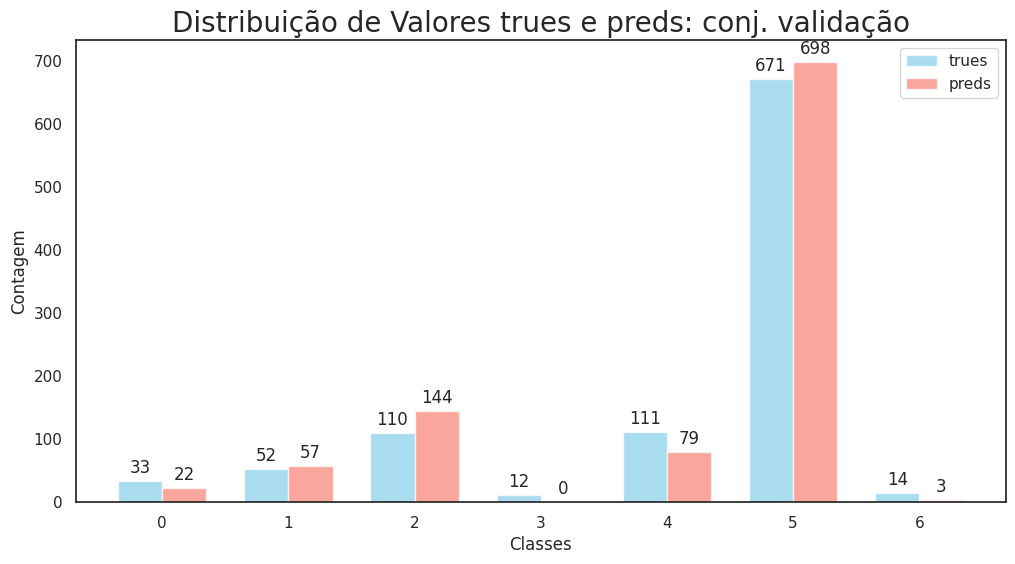

In [76]:
# Calculando os value_counts para ambas as colunas
true_counts = df['trues'].value_counts().sort_index()
preds_counts = df['preds'].value_counts().sort_index()

# Criando um dataframe de contagens para facilitar o plot
counts_df = pd.DataFrame({
    'trues': true_counts,
    'preds': preds_counts
}).fillna(0)  # Preenchendo valores NaN com 0

# Configurando os dados para o gráfico
bar_width = 0.35  # Largura das barras
index = np.arange(len(counts_df))  # Índices para as barras

# Criando o gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))

bar1 = ax.bar(index, counts_df['trues'], bar_width, label='trues', color='skyblue', alpha=0.7)
bar2 = ax.bar(index + bar_width, counts_df['preds'], bar_width, label='preds', color='salmon', alpha=0.7)

# Adicionando os valores em cima de cada barra
for bar in bar1:
    height = bar.get_height()
    ax.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom')
for bar in bar2:
    height = bar.get_height()
    ax.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom')

# Configurações do gráfico
ax.set_xlabel('Classes')
ax.set_ylabel('Contagem')
ax.set_title('Distribuição de Valores trues e preds: conj. validação', fontsize=20)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(counts_df.index)
ax.legend()

plt.show()

### Podemos observar que a classe 5 é a que possui maior quantidade de amostras no conjunto de validação. Vamos plotar o TSNE das predições

In [77]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne = tsne.fit_transform(np.stack(df['logits'].values))

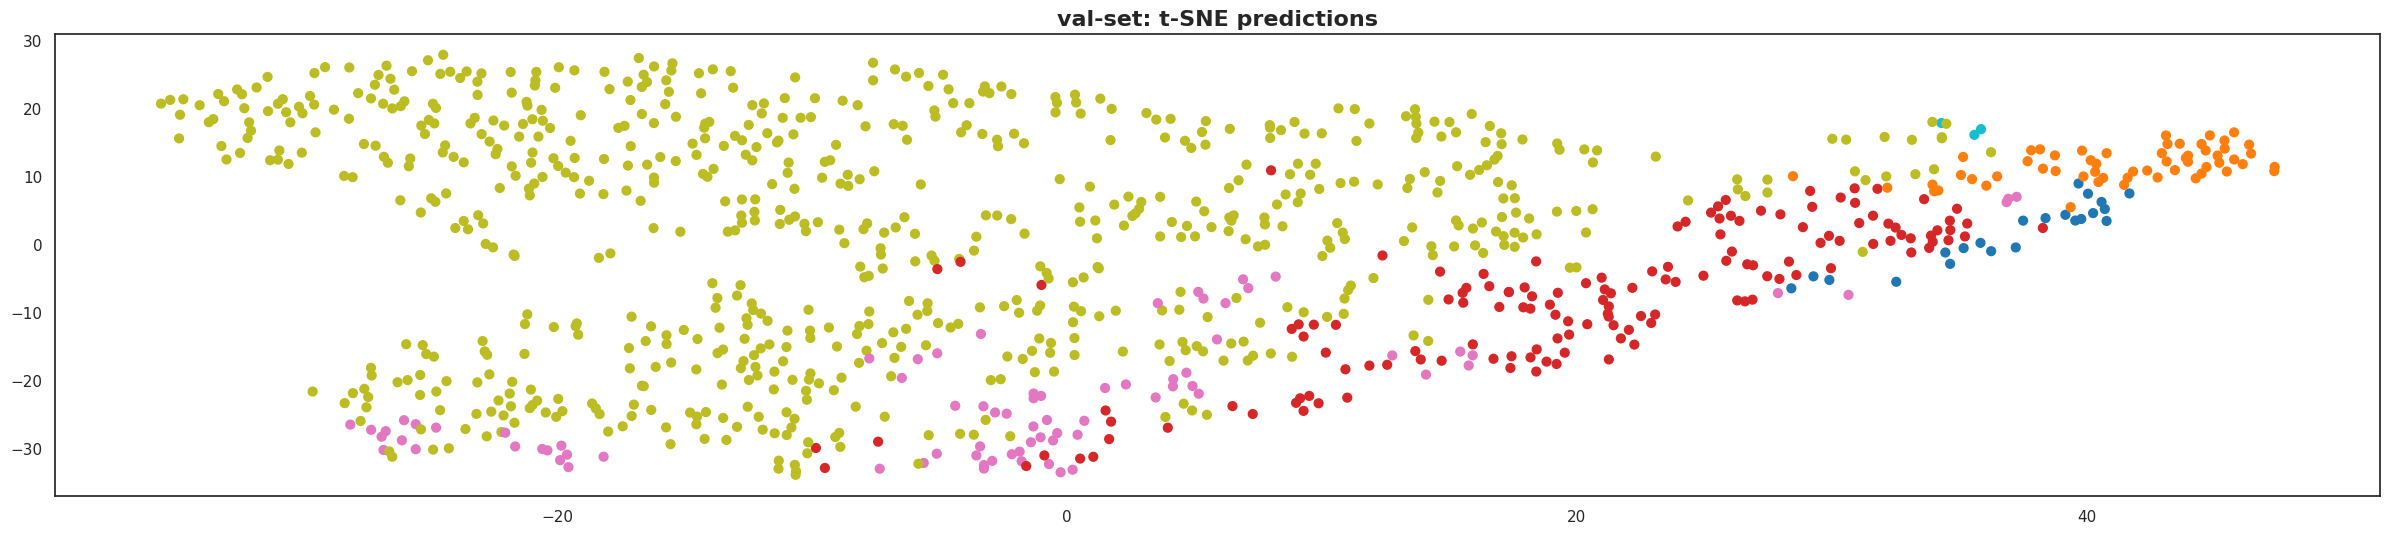

In [81]:
plt.scatter(tsne[:, 0], tsne[:, 1], c=df['preds'], cmap='tab10', s=40)
plt.title('val-set: t-SNE predictions', fontweight='bold', fontsize=16)
plt.show()

### Verificação de erro por classe
### Queremos responder a seguinte pergunta: _Para cada classe (1, 2,..., 7). Qual foi a classe que mais o modelo se confundiu? Por exemplo, o modelo fez predição classe 0, mas pelo true-label a maioria das classes eram classe 1._

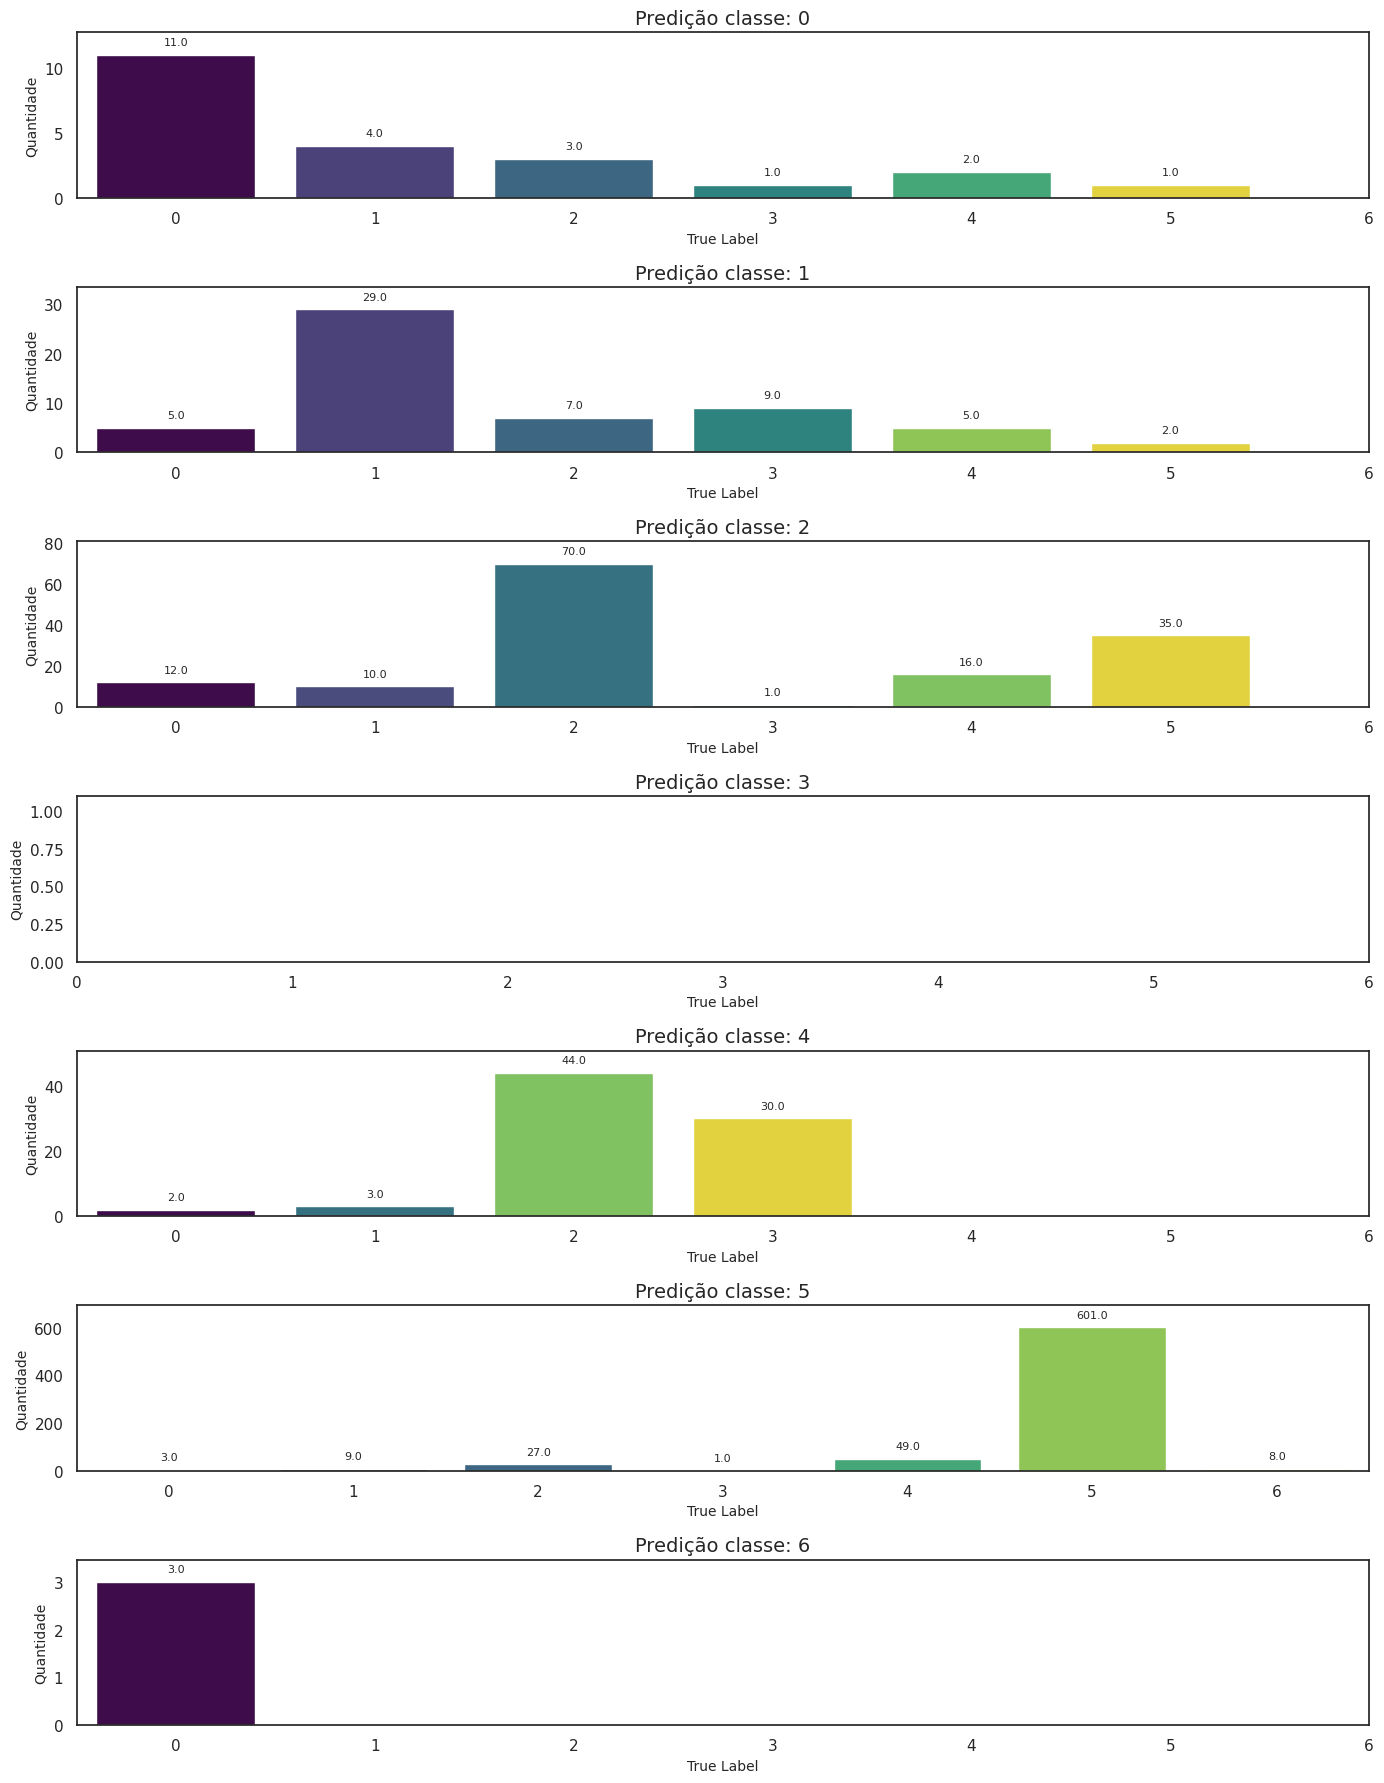

In [82]:
# Configurando o layout para 7 subplots
fig, axes = plt.subplots(7, 1, figsize=(14, 18), sharex=False)

unique_trues = sorted(df['trues'].unique())

sns.set_style("white")


# Geração dos subplots
for i in range(7):
    # Filtrar o DataFrame para a predição atual
    filtered_data = df[df['preds'] == i]['trues'].value_counts().reset_index()
    filtered_data.columns = ['trues', 'quantidade']

    # Gráfico de barras com cor da paleta Seaborn
    sns.barplot(x='trues', y='quantidade', hue='trues', data=filtered_data, ax=axes[i], palette='viridis', dodge=False, legend=False)

    # Adicionar valores acima das barras
    for p in axes[i].patches:
        axes[i].annotate(format(p.get_height(), '.1f'),
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha = 'center', va = 'center',
                         xytext = (0, 9),
                         textcoords = 'offset points', fontsize=8)

    # Configurando os eixos e título
    axes[i].set_title(f'Predição classe: {i}', fontsize=14)
    axes[i].set_xlabel('True Label', fontsize=10)
    axes[i].set_ylabel('Quantidade', fontsize=10)
    axes[i].set_xticks(range(len(unique_trues)))
    axes[i].set_xticklabels(unique_trues)

    # Ajustando o limite superior do eixo y
    ylim = axes[i].get_ylim()
    axes[i].set_ylim(ylim[0], ylim[1] * 1.1)  # Aumentando em 10%

# Ajustar o layout
plt.tight_layout()
plt.show()

## A analise de erro por classe nos leva ao grafico da Matriz de Confusão

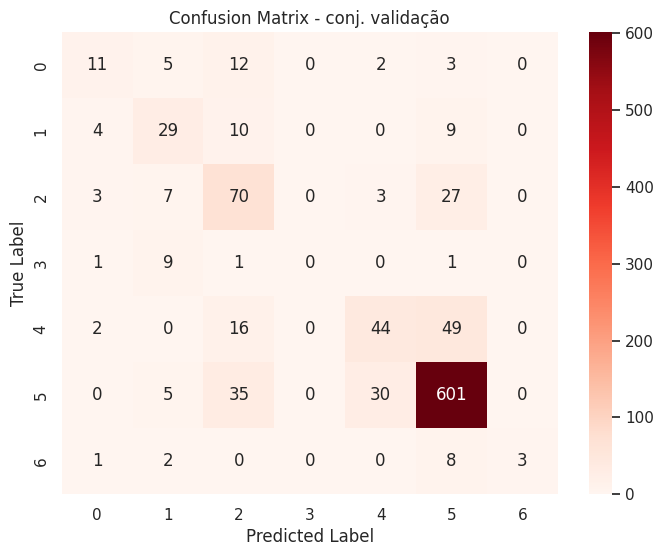

In [83]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(df['trues'], df['preds'])

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - conj. validação')
plt.show()

## Ecolhendo 10 imagems (5 da classe 4) e (5 da classe 2)

In [93]:
K = 5 # numero de exemplos

# erros e acertos da classe 4
acertos_classe4 = df[(df['preds'] == 4) & (df['trues'] == 4)].sample(n=K)
erros_classe4 = df[(df['preds'] == 4) & (df['trues'] != 4)].sample(n=K)
classe_4 = pd.concat((acertos_classe4, erros_classe4), axis=0)

# erros e acertos da classe 2
acertos_classe2 = df[(df['preds'] == 2) & (df['trues'] == 2)].sample(n=K)
erros_classe2 = df[(df['preds'] == 2) & (df['trues'] != 2)].sample(n=K)
classe_2 = pd.concat((acertos_classe2, erros_classe2), axis=0)

assert len(classe_2) == len(classe_4)

2a linha: Erros da classe 4: predições das classes (esquerda para direita) [5, 0, 5, 2, 5]


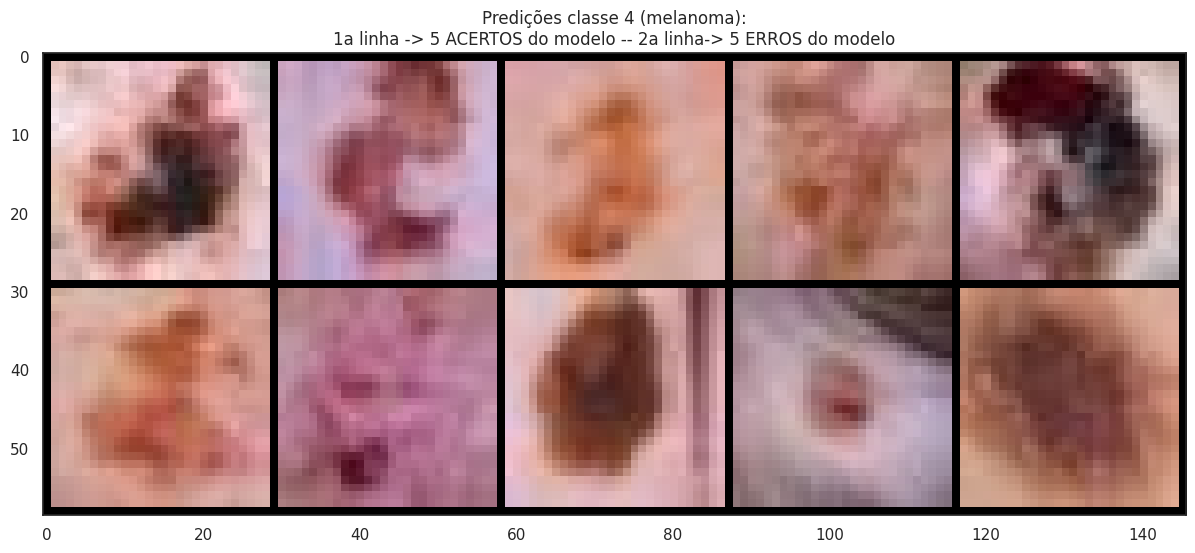

In [94]:
plt.rcParams["figure.figsize"] = (30,6)
grid = make_grid(convert_tensor(classe_4), nrow=5, padding=1)

label = """Predições classe 4 (melanoma):\n1a linha -> 5 ACERTOS do modelo -- 2a linha-> 5 ERROS do modelo"""
show(grid, label=label)
print(f"2a linha: Erros da classe 4: predições das classes (esquerda para direita) {classe_4['trues'].to_list()[5:]}")

## Do grid mostrado acima (classe 4 - melanoma). Podemos identificar que os erros do modelo são imagens bem próximas dos true-labels. Contando da 1a linha da esquerda para a direita.
- #### 2a linha, 1a imagem é muito similar a 1a linha 3a imagem
- #### 2a linha, 4a imagem é muito similar a 1a linha 3a imagem
- #### 2a linha, 5a imagem é muito similar a 1a linha 5a imagem

2a linha: Erros da classe 4: predições das classes (esquerda para direita) [5, 5, 5, 5, 3]


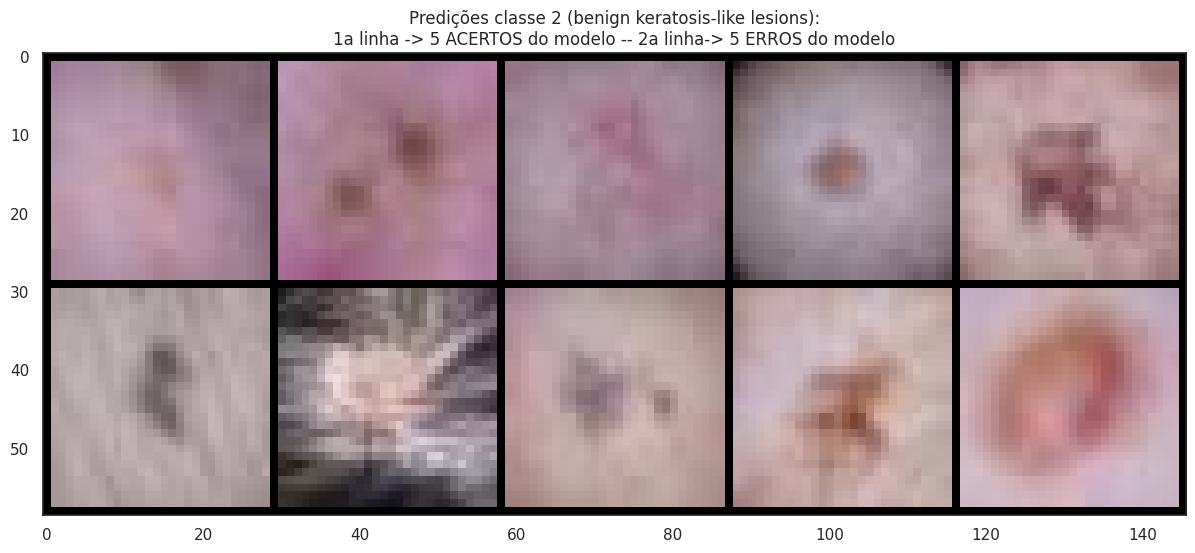

In [95]:
grid = make_grid(convert_tensor(classe_2), nrow=5, padding=1)

label = """Predições classe 2 (benign keratosis-like lesions):\n1a linha -> 5 ACERTOS do modelo -- 2a linha-> 5 ERROS do modelo"""
show(grid, label=label)
print(f"2a linha: Erros da classe 4: predições das classes (esquerda para direita) {classe_2['trues'].to_list()[5:]}")

## Do grid mostrado acima (classe 2 - benign keratosis-like lesions). Podemos identificar que os erros do modelo são imagens bem próximas dos true-labels. Contando da 1a linha da esquerda para a direita.
- #### 2a linha, 2a imagem é muito similar a 1a linha 1a imagem
- #### 2a linha, 3a imagem é muito similar a 1a linha 2a e 3a imagem
- #### 2a linha, 5a imagem é muito similar a 1a linha 4a e 5a imagem

## 3. (3,5) Utilizando o seu modelo treinado na base de dados DermaMNIST (obtido no Trabalho 1), escolha e aplique uma técnica de visualização (diferente da questão anterior). Não é necessário aplicar a técnica para todas as classes, avalie 10 imagens em duas classes, por exemplo, melanoma (4: melanoma) e ceratose (2: benign keratosis-like lesions), sendo 5 imagens nas quais o seu modelo acertou e 5 imagens nas quais o seu modelo errou. Apresente os resultados.

### Vamos seguir a abordagem do GradCam, [artigo de referência](https://arxiv.org/abs/1610.0239).

#### Grad-CAM (Gradiente-weighted Class Activation Mapping) é uma técnica de interpretação de modelos de redes neurais, especialmente usada em visão computacional. Ela destaca as regiões de uma imagem que mais contribuem para a decisão do modelo, utilizando gradientes de camadas específicas para produzir um mapa de calor. Este mapa de calor mostra visualmente quais partes da imagem influenciam mais a previsão final do modelo.

In [96]:
! pip install -q grad-cam

import warnings
warnings.filterwarnings('ignore')

import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
from PIL import Image

In [102]:
# selecionando as imagens da classe 2 e 4 e os verdadeiros true-labels.
images_classe_2, targets_classe_2 = np.stack(classe_2['images'].values), classe_2['trues'].to_list()
images_classe_4, targets_classe_4 = np.stack(classe_4['images'].values), classe_4['trues'].to_list()

# prepara a imagem para o gradcam
def prep_img_for_gradcam(img):
    img = img / 255
    input_tensor = preprocess_image(img)
    return img, input_tensor


def get_gradcam(img, target, model=model, name='1'):
    from PIL import Image
    img, input_tensor = prep_img_for_gradcam(img)
    targets = [ClassifierOutputTarget(classe_2['trues'].values[9])]

    target_layers = [model.conv1]

    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    cam = np.uint8(255*grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255*img), cam , cam_image))

    pil_image = Image.fromarray(images)

    new_size = (pil_image.width * 10, pil_image.height * 10)
    resized_image = pil_image.resize(new_size, Image.ANTIALIAS)

    resized_image.save('grad_cam_' + name +'.png')  # Para salvar a imagem redimensionada



for ix, (img2, tgt2, img4, tgt4) in enumerate(zip(
    images_classe_2, targets_classe_2,
    images_classe_4, targets_classe_4), 1
):

    get_gradcam(img2, target=tgt2, model=model, name='cl2_' + str(ix))
    get_gradcam(img4, target=tgt4, model=model, name='cl4_' + str(ix))

Modelo com predição CORRETA para a imagem abaixo - classe 2


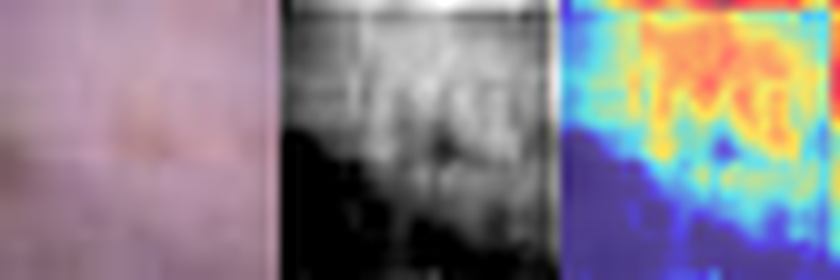

Modelo com predição CORRETA para a imagem abaixo - classe 2


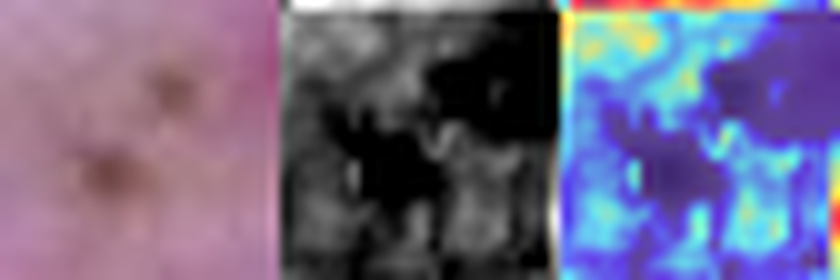

Modelo com predição CORRETA para a imagem abaixo - classe 2


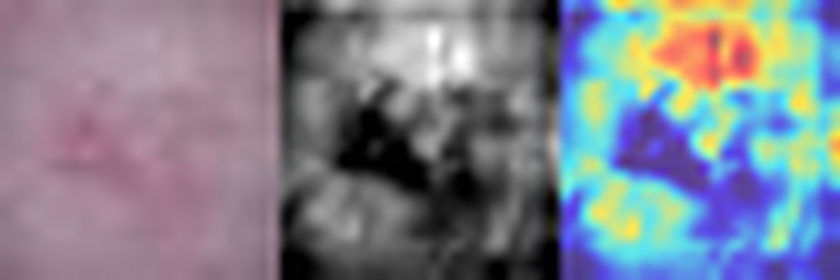

Modelo com predição CORRETA para a imagem abaixo - classe 2


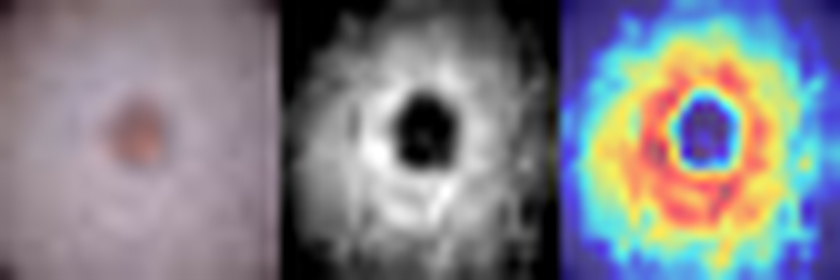

Modelo com predição CORRETA para a imagem abaixo - classe 2


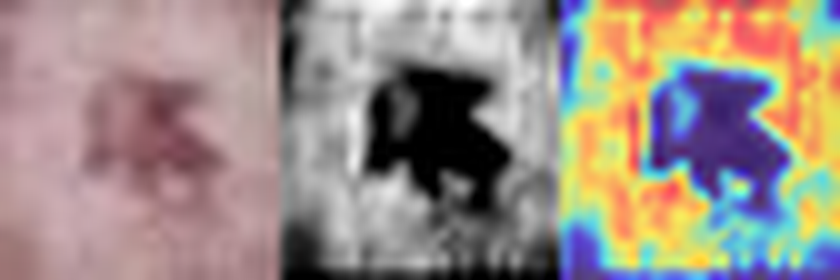

Modelo com predição ERRADA para a imagem abaixo - classe 2


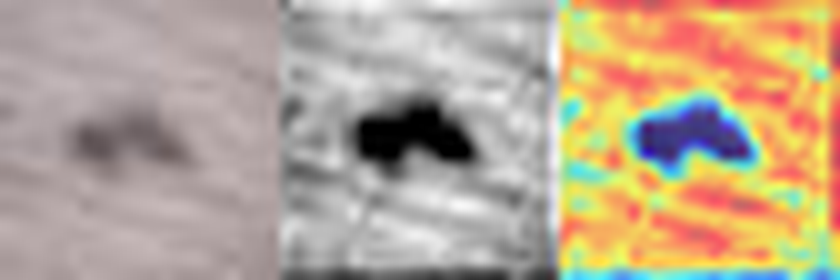

Modelo com predição ERRADA para a imagem abaixo - classe 2


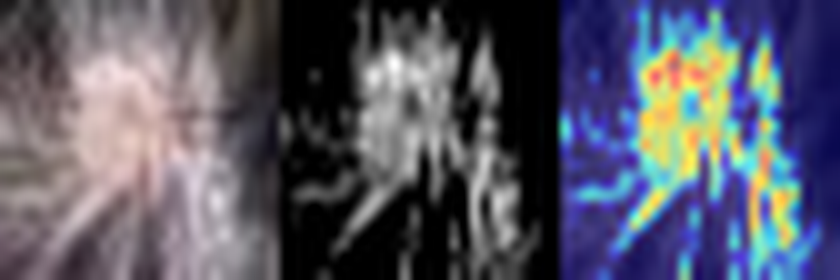

Modelo com predição ERRADA para a imagem abaixo - classe 2


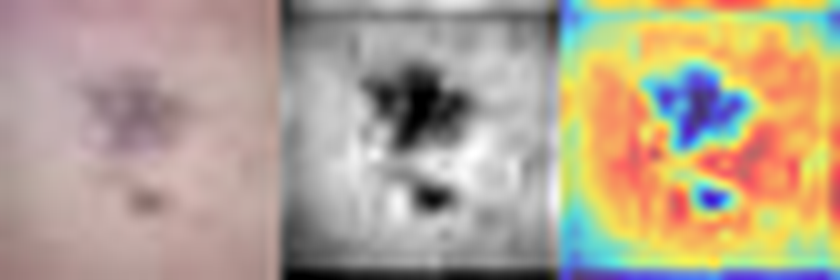

Modelo com predição ERRADA para a imagem abaixo - classe 2


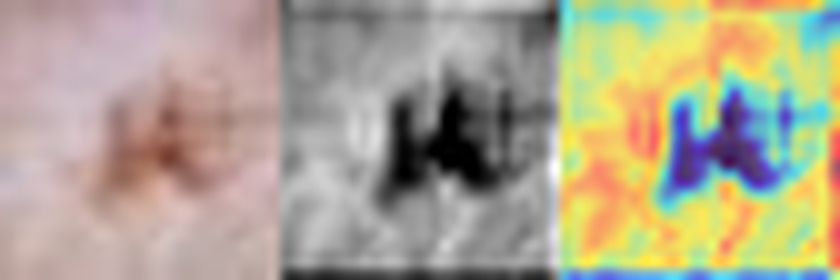

Modelo com predição ERRADA para a imagem abaixo - classe 2


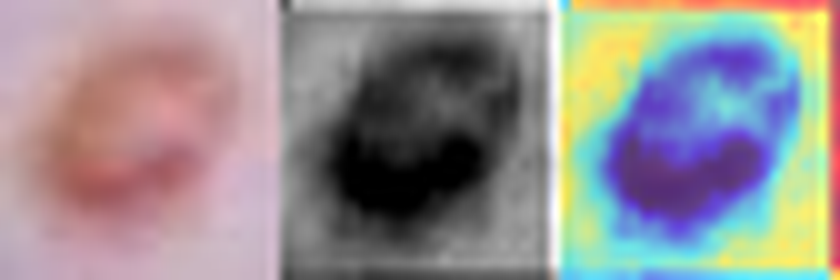

In [103]:
from IPython.display import Image, HTML

for i in range(1, 11):
    if i <=5:
        print('Modelo com predição CORRETA para a imagem abaixo - classe 2')
    else:
        print('Modelo com predição ERRADA para a imagem abaixo - classe 2')

    classe_2_model_correct = Image("/content/grad_cam_cl2_"+str(i)+".png")
    display(classe_2_model_correct)

Modelo com predição CORRETA para a imagem abaixo - classe 4


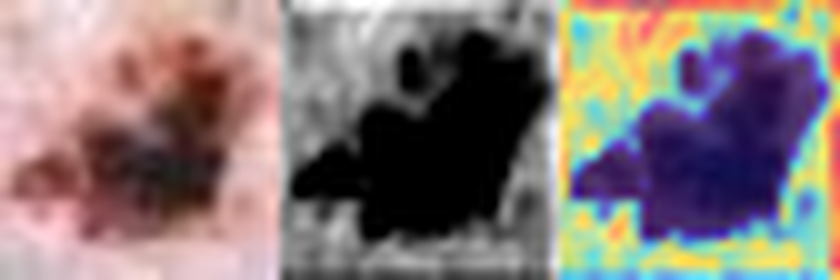

Modelo com predição CORRETA para a imagem abaixo - classe 4


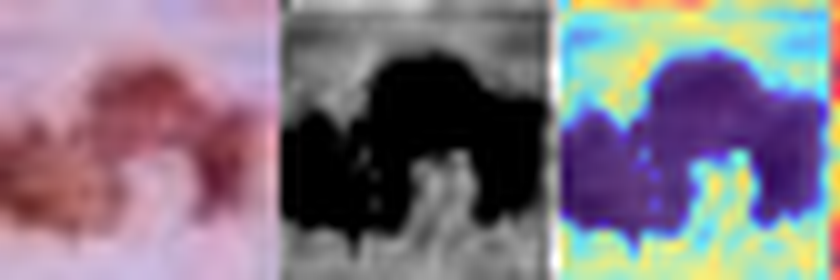

Modelo com predição CORRETA para a imagem abaixo - classe 4


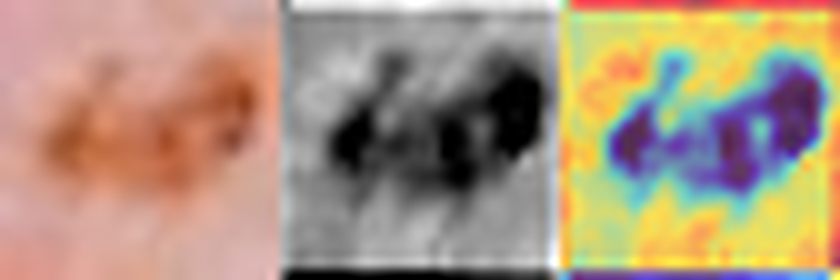

Modelo com predição CORRETA para a imagem abaixo - classe 4


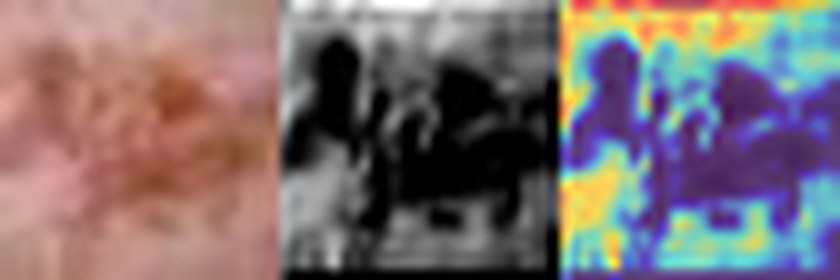

Modelo com predição CORRETA para a imagem abaixo - classe 4


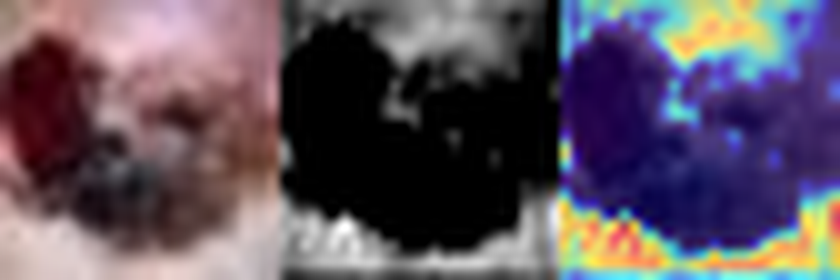

Modelo com predição ERRADA para a imagem abaixo - classe 4


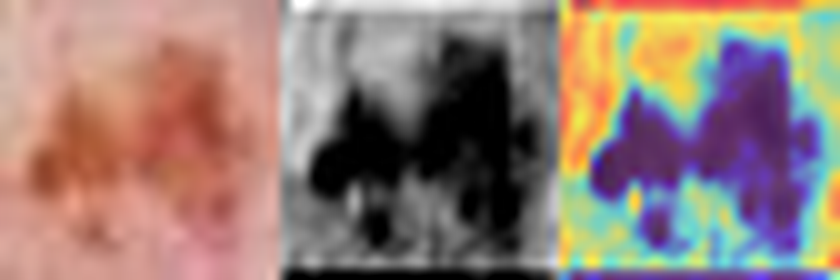

Modelo com predição ERRADA para a imagem abaixo - classe 4


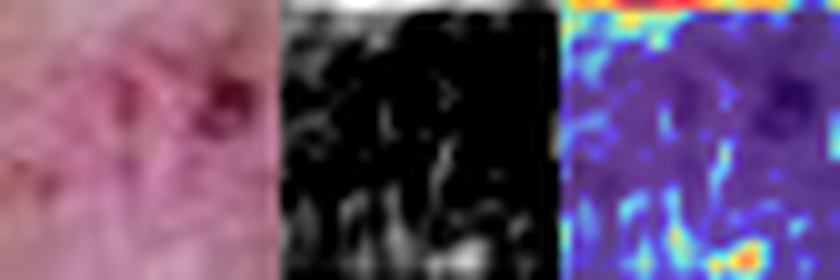

Modelo com predição ERRADA para a imagem abaixo - classe 4


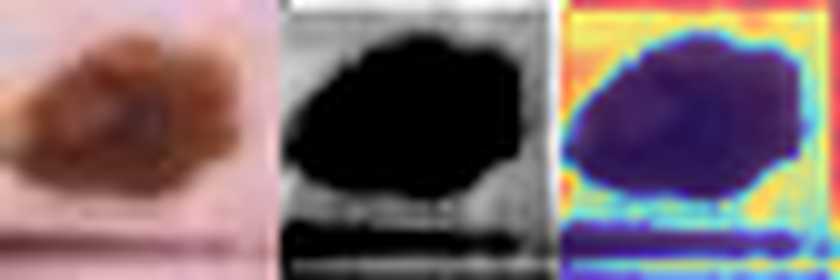

Modelo com predição ERRADA para a imagem abaixo - classe 4


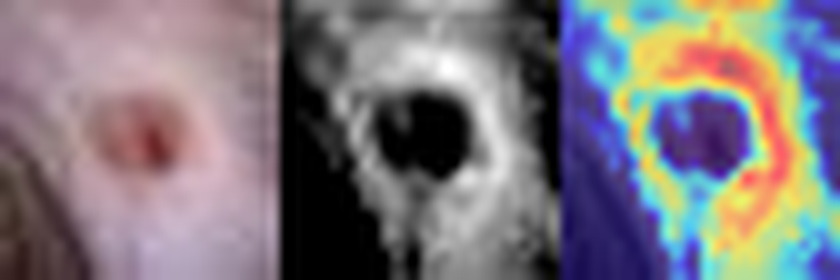

Modelo com predição ERRADA para a imagem abaixo - classe 4


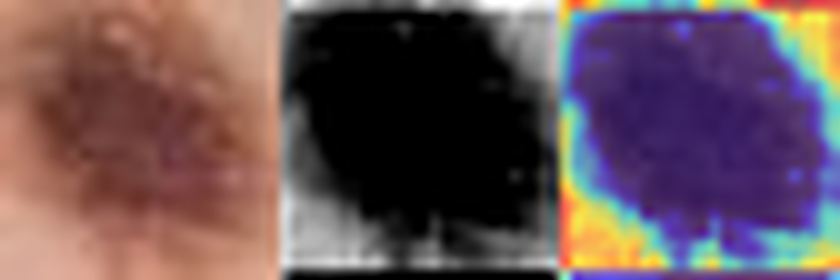

In [104]:
for i in range(1, 11):
    if i <=5:
        print('Modelo com predição CORRETA para a imagem abaixo - classe 4')
    else:
        print('Modelo com predição ERRADA para a imagem abaixo - classe 4')

    classe_4_model_correct = Image("/content/grad_cam_cl4_"+str(i)+".png")
    display(classe_4_model_correct)

## Vamos observar a detecção de borda para as imagens

In [105]:
from pytorch_grad_cam.sobel_cam import sobel_cam
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange

def edge_detector(img, target, model=model, name='1'):
    from PIL import Image
    img, input_tensor = prep_img_for_gradcam(img)
    targets = [ClassifierOutputTarget(classe_2['trues'].values[9])]

    sobel_cam_grayscale = sobel_cam(np.uint8(img * 255))
    thresholded_cam = sobel_cam_grayscale < np.percentile(sobel_cam_grayscale, 75)

    cam_metric = CamMultImageConfidenceChange()
    scores, visualizations = cam_metric(input_tensor, [thresholded_cam], targets, model, return_visualization=True)
    score = scores[0]
    visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
    visualization = deprocess_image(visualization)
    sobel_cam_rgb = cv2.merge([sobel_cam_grayscale, sobel_cam_grayscale, sobel_cam_grayscale])

    pil_image = Image.fromarray(np.hstack((np.uint8(255*img), sobel_cam_rgb, visualization)))

    new_size = (pil_image.width * 10, pil_image.height * 10)
    resized_image = pil_image.resize(new_size, Image.ANTIALIAS)

    resized_image.save('edge_detector_' + name +'.png')  # Para salvar a imagem redimensionada

for ix, (img2, tgt2, img4, tgt4) in enumerate(zip(
    images_classe_2, targets_classe_2,
    images_classe_4, targets_classe_4), 1
):

    edge_detector(img2, target=tgt2, model=model, name='cl2_' + str(ix))
    edge_detector(img4, target=tgt4, model=model, name='cl4_' + str(ix))

Modelo com predição CORRETA para a imagem abaixo - classe 2 - Edge Detector


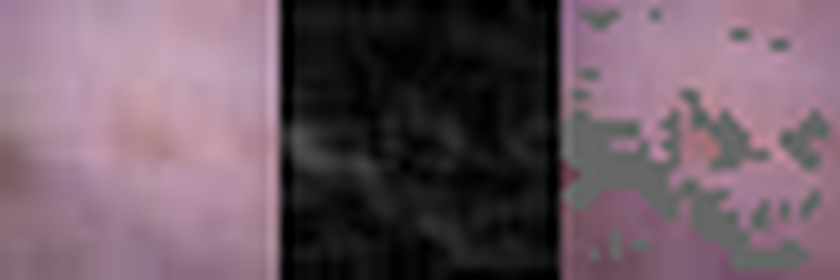

Modelo com predição CORRETA para a imagem abaixo - classe 2 - Edge Detector


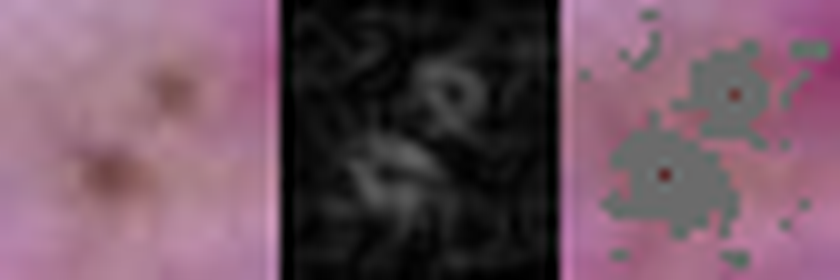

Modelo com predição CORRETA para a imagem abaixo - classe 2 - Edge Detector


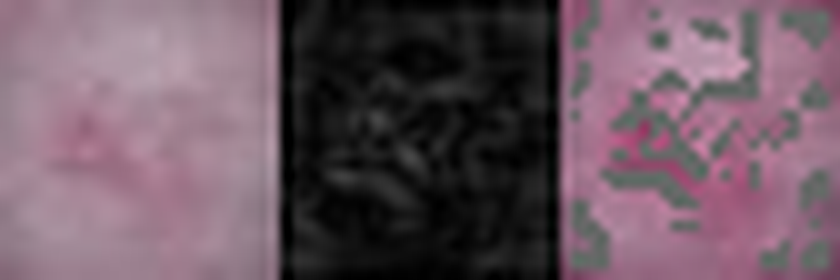

Modelo com predição CORRETA para a imagem abaixo - classe 2 - Edge Detector


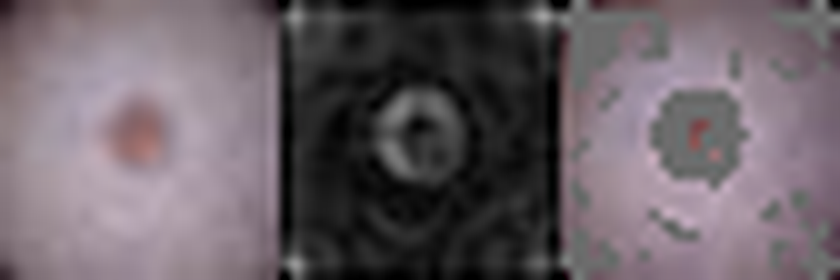

Modelo com predição CORRETA para a imagem abaixo - classe 2 - Edge Detector


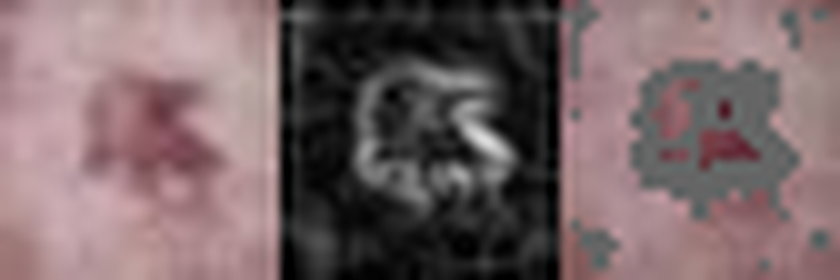

Modelo com predição ERRADA para a imagem abaixo - classe 2  - Edge Detector


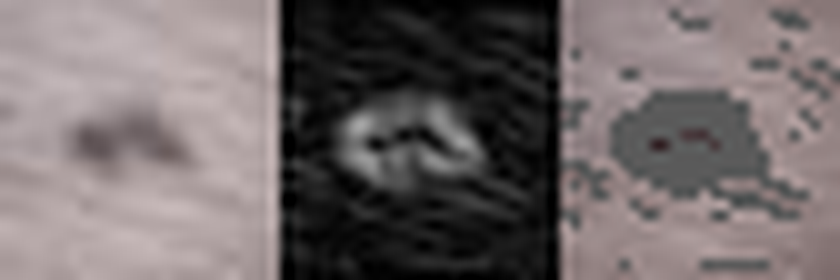

Modelo com predição ERRADA para a imagem abaixo - classe 2  - Edge Detector


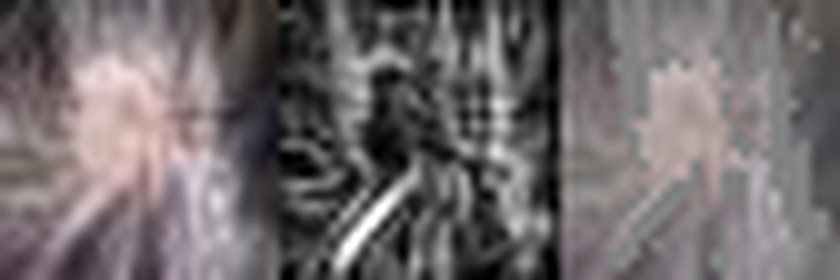

Modelo com predição ERRADA para a imagem abaixo - classe 2  - Edge Detector


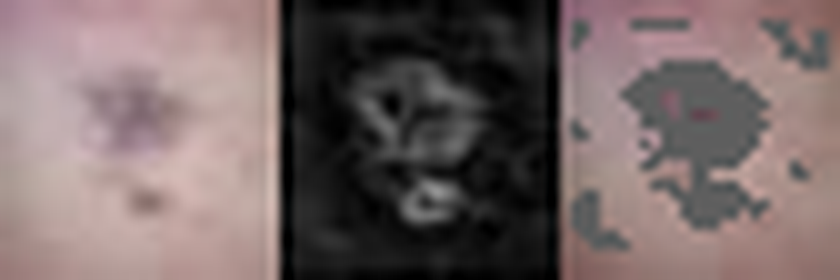

Modelo com predição ERRADA para a imagem abaixo - classe 2  - Edge Detector


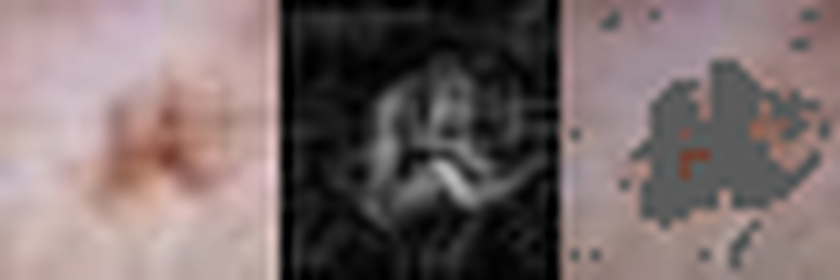

Modelo com predição ERRADA para a imagem abaixo - classe 2  - Edge Detector


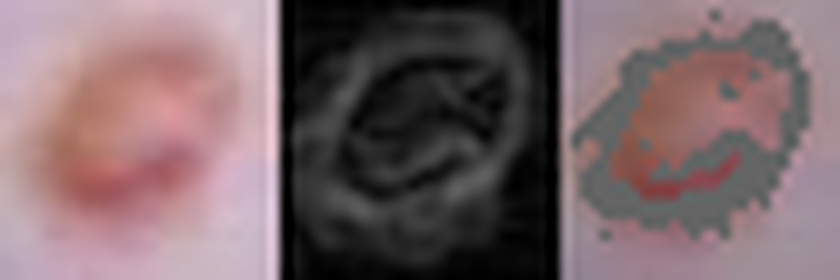

In [106]:
from IPython.display import Image, HTML

for i in range(1, 11):
    if i <=5:
        print('Modelo com predição CORRETA para a imagem abaixo - classe 2 - Edge Detector')
    else:
        print('Modelo com predição ERRADA para a imagem abaixo - classe 2  - Edge Detector')

    classe_2_model_correct = Image("/content/edge_detector_cl2_"+str(i)+".png")
    display(classe_2_model_correct)

Modelo com predição CORRETA para a imagem abaixo - classe 4 - Edge Detector


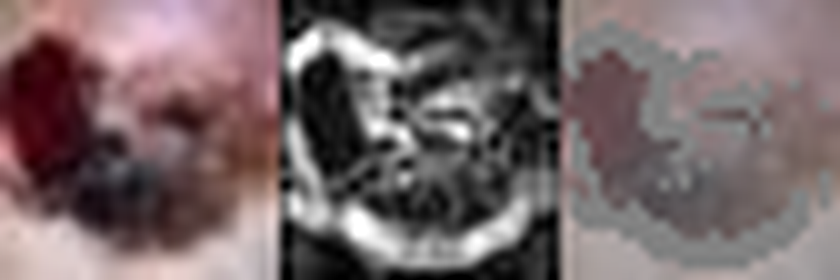

Modelo com predição CORRETA para a imagem abaixo - classe 4 - Edge Detector


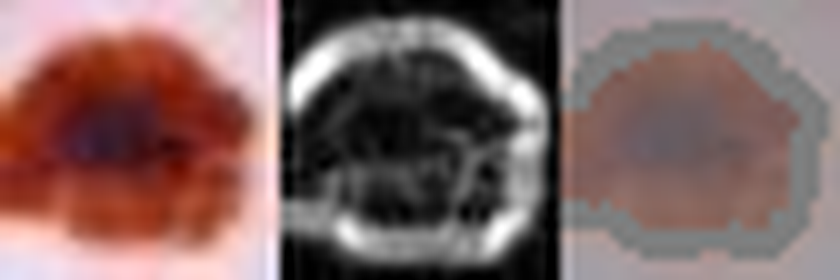

Modelo com predição CORRETA para a imagem abaixo - classe 4 - Edge Detector


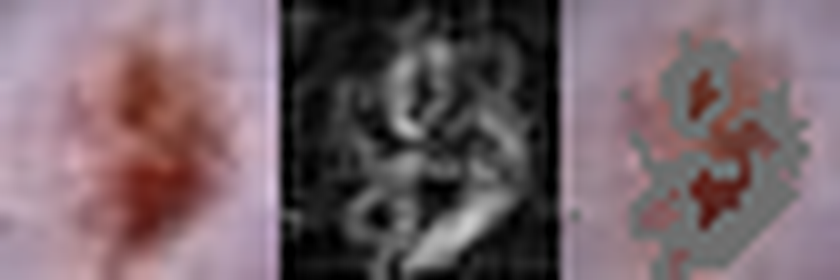

Modelo com predição CORRETA para a imagem abaixo - classe 4 - Edge Detector


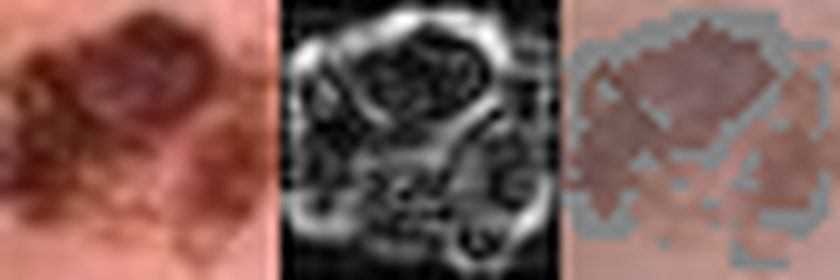

Modelo com predição CORRETA para a imagem abaixo - classe 4 - Edge Detector


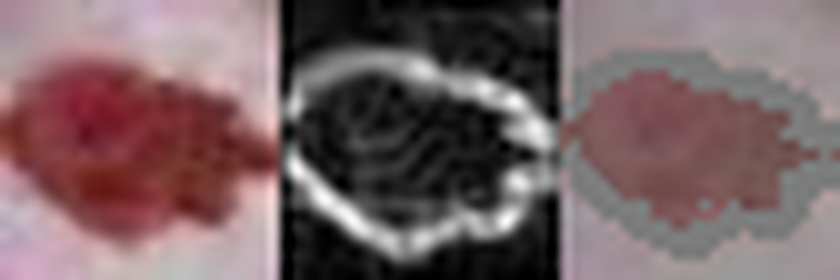

Modelo com predição ERRADA para a imagem abaixo - classe 4  - Edge Detector


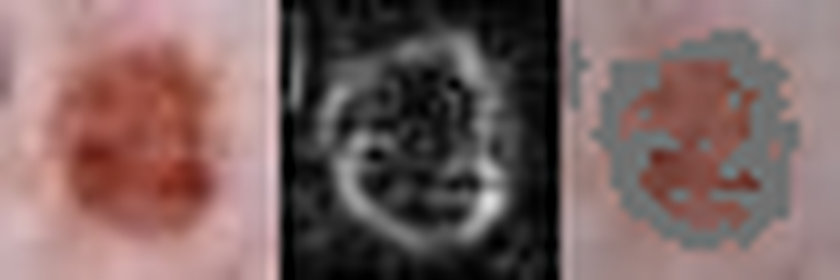

Modelo com predição ERRADA para a imagem abaixo - classe 4  - Edge Detector


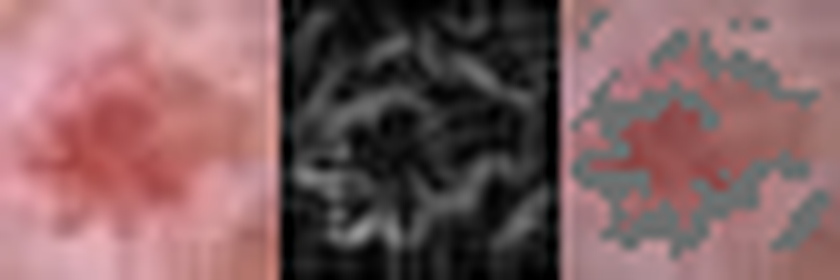

Modelo com predição ERRADA para a imagem abaixo - classe 4  - Edge Detector


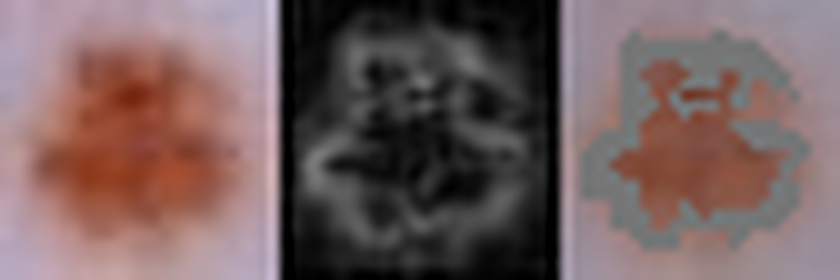

Modelo com predição ERRADA para a imagem abaixo - classe 4  - Edge Detector


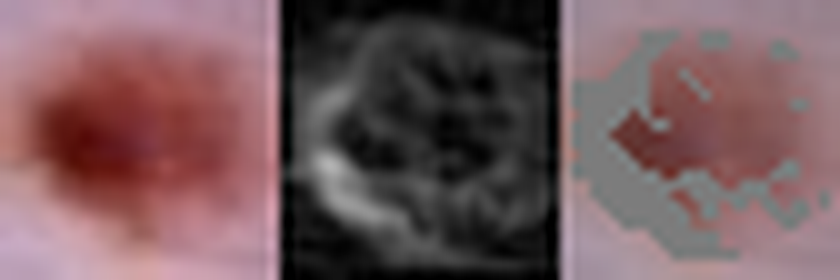

Modelo com predição ERRADA para a imagem abaixo - classe 4  - Edge Detector


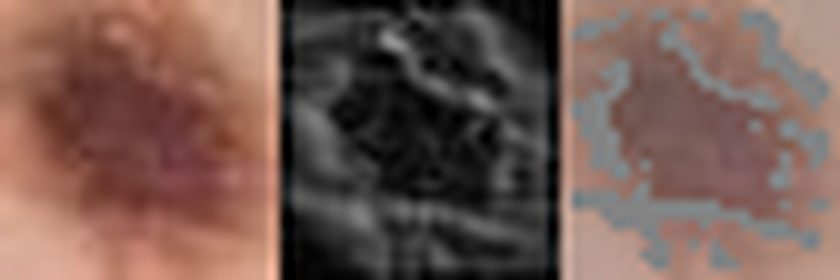

In [92]:
for i in range(1, 11):
    if i <=5:
        print('Modelo com predição CORRETA para a imagem abaixo - classe 4 - Edge Detector')
    else:
        print('Modelo com predição ERRADA para a imagem abaixo - classe 4  - Edge Detector')

    classe_4_model_correct = Image("/content/edge_detector_cl4_"+str(i)+".png")
    display(classe_4_model_correct)

# (2,0) Quais foram as conclusões para as visualizações? É possível observar o comportamento do modelo? Discuta

## Resposta

## 1a Abordagem - Análise de trues VS predições com gŕaficos de barras e matriz de confusão + analise de 10 imagens da classe 2 e classe 4.
- #### **Principal comentário:** Com analise simples da distribuição dos erros por classe, identificamos que o modelo tem dificuldades para predizer a classe 3 (errou +90% essa classe). Apesar de simples, os gráficos de barras e analise das imagens, constatamos que os erros da classe 2 (5 imagens analisadas) é difícil, mesmo para um humano (não especialista) é complicado distinguir e encontrar um padrão. Para a classe 4, observamos que os erros são mais distantes e acreditamos que existe possibilidade de melhora do modelo.

## 2a Abordagem - GradCam e detecção de borda:
- #### **Principal comentário:** Com uso do GradCam, destacamos as regiões das imagens mais contribuem para a decisão do modelo, utilizando o gradiente da última camada convolucional produzimos um mapa de calor para as 10 imagens da classe 2 e 4.
Encontramos alguns padrões na analise, mas dado a natureza do dataset, encontramos dificuldades e ambiguidades em áreas amplas ou difusas que não são facilmente interpretáveis. Acreditamos que o GradCam é uma ferramenta de auxílio e não uma prova conclusiva. Se o dataset fosse algo mais familiar, por exemplo detecção de gatos e cachorros, acreditamos que o GradCam e detecção de borda seria mais facilmente interpretado.

## Conclusão:
- #### Acreditamos que o modelo possa ser melhorado depois dessa analise. Não houve acertos do modelo para a classe 3. Alguns insights de melhoria para o modelo:
- treinar com dados balanceados
- aumentar a diversidade de transformações do dado de treino (data augmentation)
- melhorar os discriminadores (tamanho dos filtros das CNNs)